# Introduction
 
In this notebook I will apply the data from the experiments to the theory to try and predict the change in temperature senstivity of respiration as interaction change. To do this I will need to consider:

1. how to parameterise the basic growth model (i.e. dynamics in the absence of interactions)

2. how to parameterise the interactions between species

3. What we can predict exactly at the community level

# Growth model data

So for each species we have:
* $r$ - Growth Rate
* $R$ - Respiration Rate

as well as their temperature dependence's (roughly). In this section I derive these parameters from the experimental data.

In [5]:
library(tidyverse)
library(broom)
#Define boltzman constant (Ev)
k <- 8.617e-5

## Growth - $r$

In order to parameterise the growth of species and its temperature dependence we need an $r_0$ value and a $E_r$ value. 

Though the temperature dependence of growth was not directly measured we can estimate $E_r$ by using the optical density (OD) from the respiration experiments. Here the OD is known at two timepoints for each species/treatment combination across a range of temperatures. Assuming we are in exponential growth we can estimate the growth rate over this period using the formula:

$$
r = \frac{log \left( \frac{C(t)}{C(0)} \right)}{t}
$$

First we read in the data and calulate the growth rates:

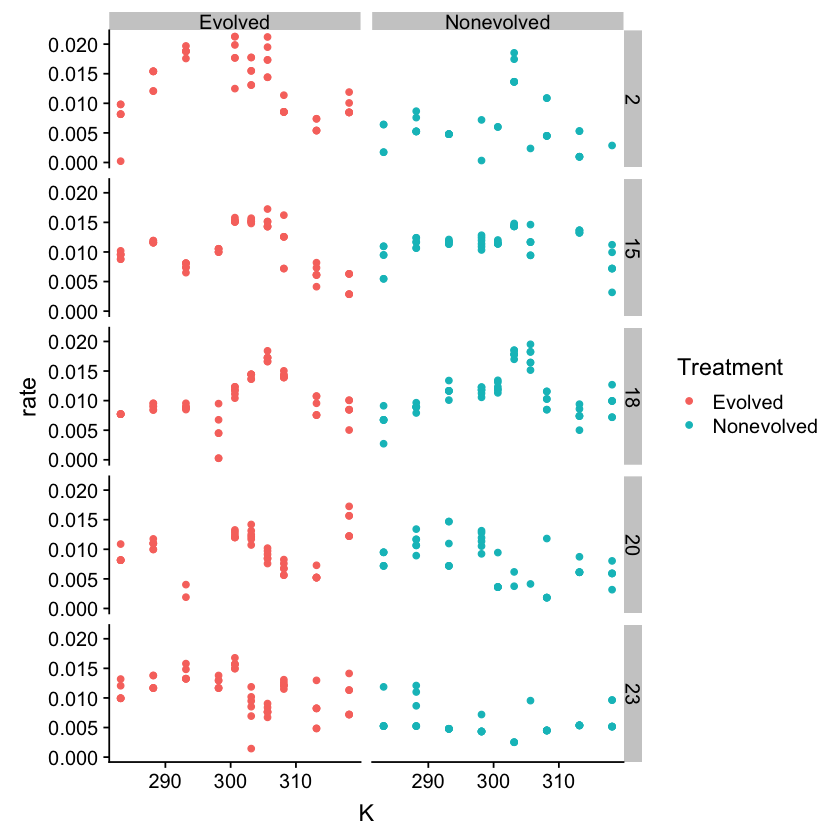

In [149]:
OTU_OD <- read_csv("../data/Francisca/respirationandODData/DatosOD_5OTUs_evNev.csv",
                   col_types = cols(
                   Replicate = col_double(),
                   OTU = col_double(),
                   OD = col_double(),
                   T = col_double(),
                   t = col_character(),
                   OD_T0 = col_double(),
                   Tf = col_double(),
                   u = col_double(),
                   Treatment = col_character()
                 ))

#get growth (need to correct for the negative growth rates)
OTU_growth <- OTU_OD %>%
    mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
    filter(r > quantile(r,probs = c(0.1))[1]) %>%
    mutate(rate = r - min(r)) %>%
    filter(rate > 0)

OTU_growth %>%
ggplot(aes(x = K, y = rate, colour = Treatment))+
geom_point()+
facet_grid(OTU~Treatment)

as we can see the TPCs are not great. However as we just need a general idea as to the temperature sensitivty we can use the approach used by Dell et al. and just fit a boltzmann to the rising portion. Though a bit rough we can do this by taking only the points that are at temperatures lower than the maximum growth rate, and taking the slope of a linear fit between $log(r) \sim \frac{1}{kT}$.

In [281]:
OTU_rising <- OTU_growth %>%
    group_by(OTU,Treatment) %>%
    mutate(rmax = max(r),Tmax = max(ifelse(r == rmax,K,0))) %>%
    filter(K <= Tmax, r > 0) %>%
    mutate(T_boltz = 1 / (K * k), r = log(r))

OTU_r_E <- OTU_rising %>%
    select(OTU,Treatment,r,T_boltz) %>%
    group_by(OTU,Treatment) %>%
    do(fit = lm(r ~ T_boltz, data = .)) %>%
    tidy(fit) %>%
    filter(term == "T_boltz") %>%
    select(OTU,Treatment,estimate) %>%
    mutate(estimate = -estimate) %>%
    rename(E = estimate) %>%
    ungroup()

OTU_r_E

OTU,Treatment,E
<dbl>,<chr>,<dbl>
2,Evolved,0.7545756
2,Nonevolved,1.1608592
15,Evolved,0.4754758
15,Nonevolved,0.2130150
18,Evolved,0.8859281
18,Nonevolved,0.7131810
20,Evolved,0.1349091
20,Nonevolved,0.6839518
23,Evolved,0.2868241


So we have the temperature sensitivty of growth but we need the r0 value to calibrate. We can get this from the full growth curves which were conducted at 20C. Here full logistic curves were measured for each species at a single temperature. thus we can get the $r_0$ value (normalised to 20 degrees) with relative ease. 

In [282]:
growth_curves <- read_csv("../data/Francisca//GrowthRate20C/Pairwise_LogisticIndivcurves_Barout.csv")

OTU_r_E <- growth_curves %>%
    filter(!str_detect(Treatment,regex("\\."))) %>%
    separate(Treatment,c("OTU","Treatment"),sep = "-") %>%
    select(OTU,Treatment,mumax) %>%
    group_by(OTU,Treatment) %>%
    summarise(r0 = mean(mumax)) %>%
    ungroup()%>%
    mutate(Treatment = recode(Treatment,!!!(c("E"="Evolved","NE" = "Nonevolved"))),
           OTU = as.numeric(OTU)) %>%
    left_join(.,OTU_r_E, by = c("OTU", "Treatment"))

OTU_r_E

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  pa = col_character(),
  LOG10Nmax = col_double(),
  LOG10N0 = col_double(),
  mumax = col_double(),
  AIC = col_double(),
  quasi.r2 = col_double(),
  Replicate = col_double(),
  Treatment = col_character()
)


OTU,Treatment,r0,E
<dbl>,<chr>,<dbl>,<dbl>
15,Evolved,0.2426918,0.4754758
15,Nonevolved,0.1501864,0.2130150
18,Evolved,0.3682850,0.8859281
18,Nonevolved,0.3533238,0.7131810
2,Evolved,0.3109008,0.7545756
2,Nonevolved,0.3168000,1.1608592
20,Evolved,0.1489258,0.1349091
20,Nonevolved,0.1395252,0.6839518
23,Evolved,0.1719664,0.2868241


Thus we have a complete parameterisation of the individual growth rates TPCs.

## Respiration

We also want to get the TPC parameters for respiration for each individual species. To do this we take the individual respiration data and directly fit the Sharpe-Scholefield model with high temperature inactivation: 

In [157]:
library(rTPC)
library(nls.multstart)

OTU_R <- read_csv("../data/Francisca/respirationandODData//RespDataLinear_OTUs_evNev.csv",
                  col_types = cols(Sps = col_character(),
                                   T = col_double(),
                                   Replicate = col_double(),
                                   Resp = col_double(),
                                   Treatment = col_character()
                                )) %>%
mutate(OTU = as.numeric(str_replace(Sps,"R_","")),
       Resp = - Resp,
       Temp = T + 273.15) %>%
        filter(Resp > 0 )


#remove 20 & Evolved outliers (should check if this is ok...)
ind <- which((OTU_R$Treatment == "evolved") & (OTU_R$OTU == 20) & (OTU_R$Resp > 3))
OTU_R <- OTU_R[-ind,]

OTU_R_fits <- OTU_R %>%
group_by(OTU,Treatment) %>%
  nest() %>%
  mutate(., ss = map(data, ~nls_multstart(Resp ~ sharpeschoolhigh_1981(temp_k = Temp, r_tref, e, eh, th, tref = 15),
                       data = .x,
                       iter = 500,
                       start_lower = get_start_vals(.x$Temp, .x$Resp, model_name = 'sharpeschoolhigh_1981') - 5,
                       start_upper = get_start_vals(.x$Temp, .x$Resp, model_name = 'sharpeschoolhigh_1981') + 5,
                       supp_errors = 'Y')))


In [158]:
#predicting fits
newdata <- tibble(Temp = seq(min(OTU_R$Temp), max(OTU_R$Temp), length.out = 100))

OTU_R_pred <- gather(OTU_R_fits, 'model', 'output', ncol(OTU_R_fits)) %>%
  unnest(., output %>% map(augment, newdata = newdata))


OTU_R_E <- gather(OTU_R_fits, 'model', 'output', ncol(OTU_R_fits)) %>%
  mutate(., est = map(output, est_params)) %>%
  select(., -c(data, output)) %>%
  unnest(est)


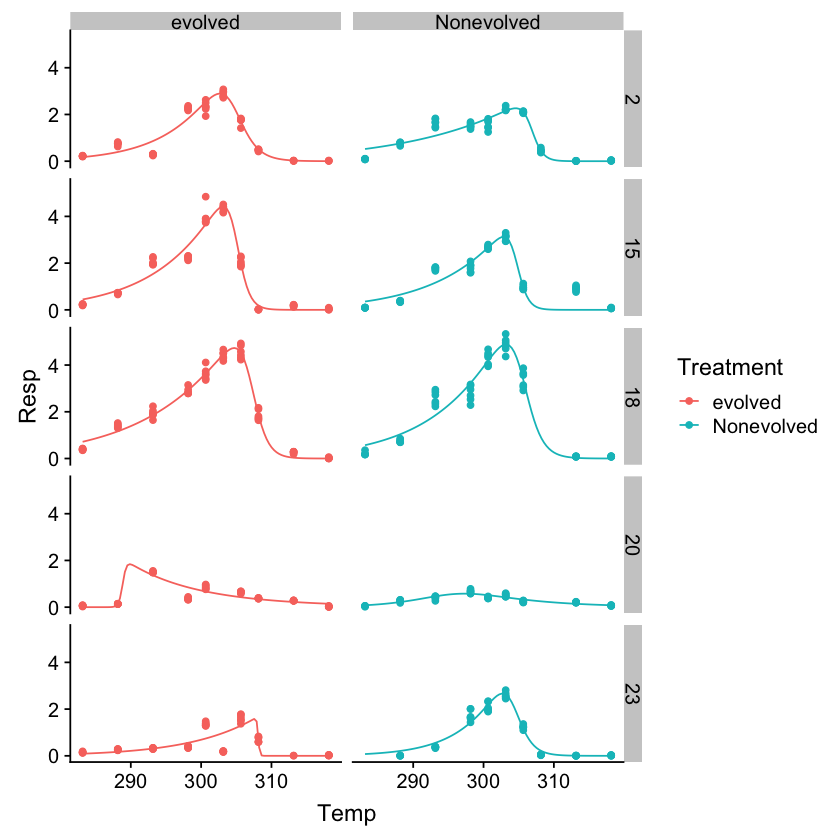

In [159]:
OTU_R %>%
    ggplot(aes(x=Temp,y = Resp,colour=Treatment))+
    geom_point()+
    facet_grid(OTU~Treatment) + 
    geom_line(data = OTU_R_pred, aes(y =`.fitted`))

TPCs for respiration!!

We can see that though some of the fits are slightly strange they are all relatively reasonable...

# Interactions

In this section I work out the parameterisation of interactions from the experimental data. From the experiments we can obtain measurements of growth rates for each pairwise combination of species across a range of temperatures. As we have also characterised the growth of each species in isolation, we can generate a null expectation of what growth rate we would see if species did not interact (and just grew in exponential growth) which is given by the differential equation:

$$
\frac{dC_{null}}{dt} = \frac{dC_1}{dt} + \frac{dC_2}{dt} = r_1 C_1 + r_2 C_2
$$

and its solution, assuming both species are in equal amounts at $t_0$:

$$
C_{null}(t) = C_1(t) + C_2(t) = \frac{C_{null}(0)}{2} \left(e^{r_1 t} + e^{r_2 t} \right)
$$

We can numerically approximate this equation in exponential form (by fitting a linear model in log space):

$$
C_{null}(0) e^{r_{null} t}
$$

where $r_{null}$ is the growth rate we expect when species do not interact.

Next we need to turn this into an actual interaction term. To do this we need to make some assumptions about the actual dynamics in the system. I use a basic lotka-volterra type model:

$$
\frac{dC_i}{dt} = C_i (r_i + \sum^N_{i \neq j} a_{ij} C_j)
$$

where again $C_i$ is the biomass of species $i$, $r_i$ its growth rate and $a_{ij}$ represents the effect of interactions on the growth of species $i$ by $j$. Note that there is no intraspecific interactio term here. Though this would be desirable it not possible to parameterise this from the data and it can be argueed that as we are considering the exponential phase of growth it should not be particulary relevant. 

To get an expression for the interaction terms $a$ we need to make a few definitions and some assumptions reguarding the model. Firstly, we assume that the interaction matrix is symmetrical (i.e. $a_{ij} = a_{ji}$). Considering the case of a two species system we can write the change in total biomass of the system as:

\begin{align}
\frac{dC_{pair}}{dt} &= \frac{dC_1}{dt} + \frac{dC_2}{dt}  \\
                    &= C_1 (r_1 + a_{ij} C_2) + C_2 (r_2 + a_{ij} C_1) \\
                    &= C_1 r_1 + C_2 r_2 + 2 C_1 C_2 a_{ij}
\end{align}

Then using the definition of the growth rate in the null case (with no interactions), $\frac{dC_{null}}{dt} = C_1 r_1 + C_2 r_2$, we can write the equation for the paired biomass as:

\begin{align}
\frac{dC_{pair}}{dt} &= C_1 r_1 + C_2 r_2 + 2 C_1 C_2 a_{ij} \\
                     &= \frac{dC_{null}}{dt} + 2 C_1 C_2 a_{ij} 
\end{align}

and rearange for the interaction term:

$$
a_{ij} = \frac{\frac{dC_{pair}}{dt} - \frac{dC_{null}}{dt}}{2 C_1 C_2}
$$

Assuming that the biomasses of each species are equal when the experiment starts ($t = 0$) we can rewrite $C_1 = C_2 = \frac{C_{pair}}{2}$ . We can also use the alernative defintions of $\frac{dC_{pair}}{dt} = C_{pair} r_{pair}$ and rewrite the whole interaction term as:


\begin{align}
a_{ij} &= \frac{C_{pair} r_{pair} - \frac{C_{pair}}{2} r_1 - \frac{C_{pair}}{2} r_2}{2 \left(\frac{C_{pair}}{2}\right)^2} \\
\\
&= \frac{2 r_{pair} - r_1 - r_2 }{C_{pair}}
\end{align}

Thus we have a way to work out the interaction between two species from the pairwise data! As we already have the values of paired growth rates this caluclation is easy.

The first step is to work out the TPC parameters for the paired growth. First the $E$ values:

In [365]:
#read in data
pairs_growth <- read_csv("../data/Francisca/respirationandODData/DatosOD_PairsevNev_u.csv",
                         col_types = cols(
                                      Replicate = col_double(),
                                      OTU = col_character(),
                                      OD = col_double(),
                                      T = col_double(),
                                      t = col_character(),
                                      OD_T0 = col_double(),
                                      Tf = col_double(),
                                      u = col_double(),
                                      Treatment = col_character()
                         ))


pairs_growth_data <- pairs_growth %>%
    mutate(OTU = str_replace(OTU,"Feb","2")) %>%
    separate(OTU,c("OTU_1","OTU_2"),sep = "-")%>%
#get growthrate (k) and temp in kelvin (K)
     mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
#clean up data 
    mutate(r = r - min(r),
           OTU_1 = as.numeric(OTU_1),
           OTU_2 = as.numeric(OTU_2),
           Treatment = str_to_title(Treatment)) %>%
    filter(r != 0)

pairs_grow_fits <- pairs_growth_data %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    nest() %>%
    mutate(., ss = map(data, ~nls_multstart(r ~ sharpeschoolhigh_1981(temp_k = K, r_tref, e, eh, th, tref = 20),
                       data = .x,
                       iter = 500,
                       start_lower = get_start_vals(.x$K, .x$r, model_name = 'sharpeschoolhigh_1981') - 5,
                       start_upper = get_start_vals(.x$K, .x$r, model_name = 'sharpeschoolhigh_1981') + 5,
                       supp_errors = 'Y')))


Warning message in runif(iter, .x, .y):
“NAs produced”

In [385]:
#predicting fits
newdata <- tibble(K = seq(min(pairs_growth_data$K), max(pairs_growth_data$K), length.out = 100))

pairs_grow_pred <- gather(pairs_grow_fits, 'model', 'output', ncol(pairs_grow_fits)) %>%
    unnest(., output %>% map(augment, newdata = newdata))


pair_grow_E <- gather(pairs_grow_fits, 'model', 'output', ncol(pairs_grow_fits)) %>%
  mutate(., est = map(output, est_params)) %>%
  select(., -c(data, output)) %>%
  unnest(est)

pair_grow_E

Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in min(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to min; returning Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in min(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to min; returning Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”Warning message in max(newdata_extrap[, param_ind], na.rm = TRUE):
“no non

OTU_1,OTU_2,Treatment,model,rmax,topt,ctmin,ctmax,e,eh,q10,thermal_safety_margin,tolerance_range,skewness
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,15,Evolved,ss,0.08747009,301.448,-Inf,363.420,0.007707368,0.11158594,1.0101893,61.972,Inf,2.398379e-03
2,18,Evolved,ss,0.09184486,308.212,-Inf,342.654,0.031441317,0.13181743,1.0427407,34.442,Inf,-2.964349e-16
2,20,Evolved,ss,0.08644572,309.415,-Inf,339.585,0.021733601,0.10962571,1.0292867,30.170,Inf,-2.964349e-16
2,23,Evolved,ss,0.08677433,296.260,-Inf,Inf,-0.058179049,0.03249510,0.9213567,Inf,Inf,-2.964349e-16
15,18,Evolved,ss,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
15,20,Evolved,ss,0.08504964,301.085,-Inf,Inf,0.012623888,0.05310287,1.0173637,Inf,Inf,-2.964349e-16
15,23,Evolved,ss,0.08791930,303.517,-Inf,349.216,0.018297369,0.17853054,1.0250763,45.699,Inf,2.398379e-03
18,20,Evolved,ss,0.08736083,306.481,-Inf,Inf,0.046563642,0.05787167,1.0651000,Inf,Inf,-2.964349e-16
18,23,Evolved,ss,0.08504535,302.295,-Inf,357.750,0.013210498,0.12483442,1.0178894,55.455,Inf,2.398379e-03


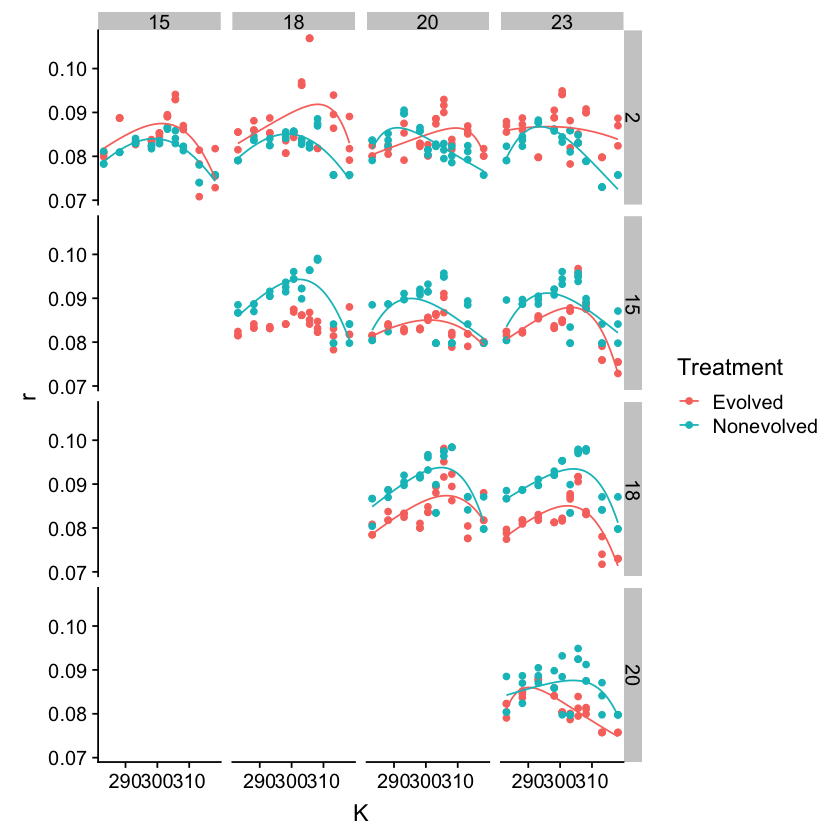

In [364]:
pairs_growth_data %>%
    ggplot(aes(x=K,y = r,colour=Treatment))+
    geom_point()+
    facet_grid(OTU_1~OTU_2)+
    geom_line(data = pairs_grow_pred, aes(y =`.fitted`))

and then the $r_0$ values

In [402]:
#interactions growth data
growth_curves <- read_csv("../data/Francisca//GrowthRate20C/Pairwise_LogisticIndivcurves_Barout.csv",
                          col_types = cols(
                                          X1 = col_double(),
                                          pa = col_character(),
                                          LOG10Nmax = col_double(),
                                          LOG10N0 = col_double(),
                                          mumax = col_double(),
                                          AIC = col_double(),
                                          quasi.r2 = col_double(),
                                          Replicate = col_double(),
                                          Treatment = col_character()
                                          ))

#get the pairs
pair_grw <- growth_curves %>% filter(str_detect(Treatment,regex("[0-9]*\\.[0-9]*",ignore_case = T)))
pair_grw_r0 <- pair_grw %>%
    separate(pa,c("x","y"),sep = "-") %>%
    separate(x,c("OTU_1","OTU_2")) %>%
    separate(y,c("Treatment","Replicate"),sep = ":") %>%
    select(OTU_1,OTU_2,Treatment,Replicate,r0 = mumax) %>%
    mutate(Treatment = recode(Treatment,"E" = "Evolved", "NE" = "Nonevolved"))

pair_grw_r0

Warning message:
“Missing column names filled in: 'X1' [1]”

OTU_1,OTU_2,Treatment,Replicate,r0
<chr>,<chr>,<chr>,<chr>,<dbl>
15,18,Evolved,R1,0.1601670
15,18,Evolved,R2,0.1118508
15,18,Evolved,R3,0.1198165
15,18,Evolved,R4,0.1197483
15,18,Evolved,R5,0.1072075
15,18,Evolved,R6,0.1462741
15,18,Nonevolved,R1,0.3641959
15,18,Nonevolved,R2,0.3869097
15,18,Nonevolved,R3,0.3594997


In [ ]:
Now we have both the TPC

In [283]:
#read in data
pairs_growth <- read_csv("../data/Francisca/respirationandODData/DatosOD_PairsevNev_u.csv",
                         col_types = cols(
                                      Replicate = col_double(),
                                      OTU = col_character(),
                                      OD = col_double(),
                                      T = col_double(),
                                      t = col_character(),
                                      OD_T0 = col_double(),
                                      Tf = col_double(),
                                      u = col_double(),
                                      Treatment = col_character()
                         ))


#create index for r0 and E values
r0_ind <- c(OTU_r_E$r0)
names(r0_ind) <- paste(OTU_r_E$OTU,OTU_r_E$Treatment,sep="-")

E_ind <- c(OTU_r_E$E)
names(E_ind) <- paste(OTU_r_E$OTU,OTU_r_E$Treatment,sep="-")

#parse interactions
pairs_growth_data <- pairs_growth %>%
    mutate(OTU = str_replace(OTU,"Feb","2")) %>%
    separate(OTU,c("OTU_1","OTU_2"),sep = "-")%>%
#get growthrate (k) and temp in kelvin (K)
     mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
#clean up data 
    mutate(r = r - min(r),
           OTU_1 = as.numeric(OTU_1),
           OTU_2 = as.numeric(OTU_2),
           Treatment = str_to_title(Treatment)) %>%
#get index names
    mutate(r0_1 = paste(OTU_1,Treatment,sep = "-"),E_1 = r0_1,
           r0_2 = paste(OTU_2,Treatment,sep = "-"),E_2 = r0_2) %>%
#recode to get r0 and E values    
    mutate(r0_1 = recode(r0_1,!!!r0_ind),E_1 = recode(E_1,!!!E_ind),
           r0_2 = recode(r0_2,!!!r0_ind),E_2 = recode(E_2,!!!E_ind)) %>%
#work out r values (at a given Temp)
    mutate(r_1 = r0_1 * exp(-(E_1 / k) * ((1 / K)-(1/293.15)) ),
           r_2 = r0_2 * exp(-(E_2 / k) * ((1 / K)-(1/293.15)) )) %>%
    select(Replicate,OTU_1,OTU_2,Treatment,K,OD_T0,OD,r_pair = r,r_1,r_2) %>%
    mutate(a = (2*r_pair - r_1 - r_2)/OD_T0) %>%
    filter(K < 300)

pairs_growth_data

Replicate,OTU_1,OTU_2,Treatment,K,OD_T0,OD,r_pair,r_1,r_2,a
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,15,Evolved,283.15,0.002125,0.003250,0.08083303,0.1082565,0.1248398,-33.61422
2,2,15,Evolved,283.15,0.002125,0.002250,0.07991371,0.1082565,0.1248398,-34.47945
3,2,15,Evolved,283.15,0.002125,0.003250,0.08083303,0.1082565,0.1248398,-33.61422
1,2,18,Evolved,283.15,0.000125,0.001250,0.08552728,0.1082565,0.1067237,-351.40522
2,2,18,Evolved,283.15,0.000125,0.000250,0.08150369,0.1082565,0.1067237,-415.78273
3,2,18,Evolved,283.15,0.000125,0.001250,0.08552728,0.1082565,0.1067237,-351.40522
1,2,20,Evolved,283.15,0.001125,0.001250,0.08003422,0.1082565,0.1233261,-63.56813
2,2,20,Evolved,283.15,0.001125,0.001250,0.08003422,0.1082565,0.1233261,-63.56813
3,2,20,Evolved,283.15,0.001125,0.003250,0.08242300,0.1082565,0.1233261,-59.32141


This dataframe contains the logistic fits for all pairwise combinations in addition to the single species curves. thus, we need to separate these out

In [13]:
#split single species and pairwise fits
pair_grw <- growth_curves %>% filter(str_detect(Treatment,regex("[0-9]*\\.[0-9]*",ignore_case = T)))
sing_grw <- growth_curves %>% filter(!str_detect(Treatment,regex("[0-9]*\\.[0-9]*",ignore_case = T)))

#tidy up growthrates
single <- sing_grw %>% 
    separate(Treatment,c("OTU","Treatment")) %>%
    select(OTU,Treatment,Replicate,K = LOG10Nmax,N0 = LOG10N0,r = mumax) %>%
    mutate(K = 10^K, N0 = 10^N0)

pairwise <- pair_grw %>%
    separate(Treatment,c("OTU","Treatment"),sep = "-") %>%
    separate(OTU,c("OTU_1","OTU_2")) %>%
    select(OTU_1,OTU_2,Treatment,Replicate,K = LOG10Nmax,N0 = LOG10N0,r = mumax) %>%
    mutate(K = 10^K, N0 = 10^N0)


In [82]:
##estimating growth rates
#summarise growth rates across groups
mean_r_single <- single %>% group_by(OTU,Treatment) %>%
    summarise(r = mean(r))

mean_r_pair <- pairwise %>% group_by(OTU_1,OTU_2,Treatment) %>%
    summarise(r = mean(r), N0 = mean(N0))

#function to get the expected growth with no interactions (via linearlised exponential growth)
get_pair_r_exp <- function(Treat,OTU_1,OTU_2,N0,t_max){
    #get growth rates
    r_vec <- mean_r_single %>%
    filter(Treatment == Treat, OTU %in% c(OTU_1,OTU_2)) %>%
    .$r
    
    #allocate N vector
    N_vec <- vector(length = 100)
    for(i in 1:100){
        N_vec[i] <- sum(rep(N0,2) * exp(r_vec*seq(0,t_max,length.out = 100)[i]))
    }

    r_pair = coef(lm(log(N_vec)~seq(0,t_max,length.out = 100)))[2]

    return(r_pair)
}

r_interactions <- mean_r_pair %>%
    mutate(r_null = get_pair_r_exp(Treatment,OTU_1,OTU_2,N0/2,10),
           r_diff = r / r_null)

r_interactions

OTU_1,OTU_2,Treatment,r,N0,r_null,r_diff
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
15,18,E,0.12751070,0.021071364,0.3174811,0.4016324
15,18,NE,0.40513504,0.008334477,0.3174811,1.2760919
15,20,E,0.18259778,0.016120275,0.1755808,1.0399643
15,20,NE,0.13705277,0.021931893,0.1755808,0.7805680
15,23,E,0.19435895,0.012274014,0.1788188,1.0869044
15,23,NE,0.11722597,0.012994489,0.1788188,0.6555573
18,20,E,0.29915044,0.007625384,0.3027300,0.9881758
18,20,NE,0.32361771,0.010798027,0.3027300,1.0689979
18,23,E,0.34911981,0.002472549,0.3015289,1.1578318


And for the $E$ values we again look at the respiration measures:

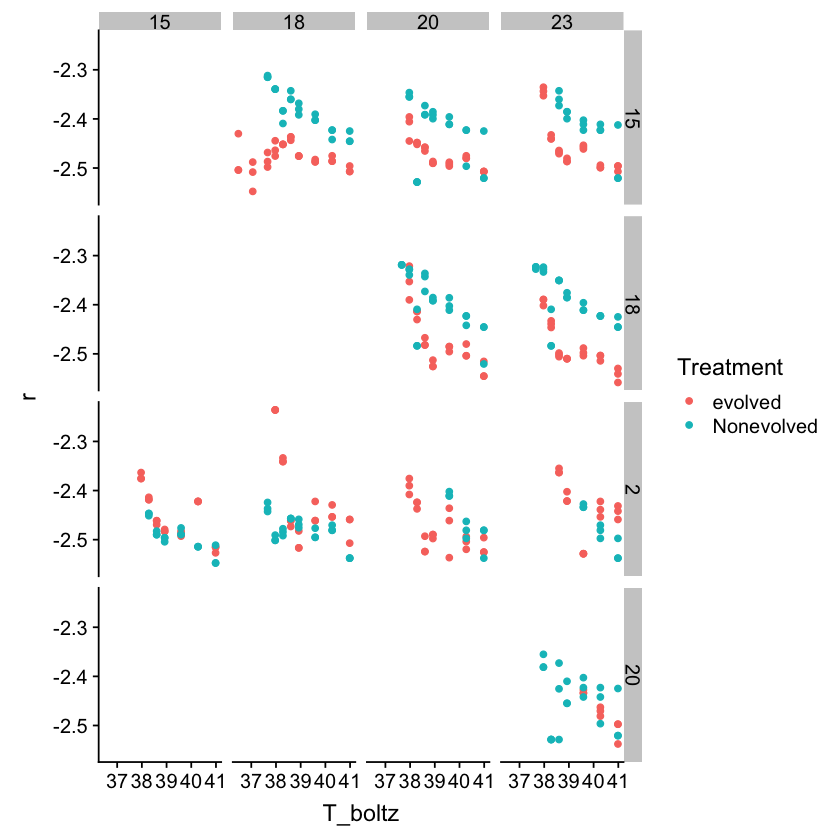

In [83]:
pairs_growth <- read_csv("../data/Francisca/respirationandODData/DatosOD_PairsevNev_u.csv",
                         col_types = cols(
                                      Replicate = col_double(),
                                      OTU = col_character(),
                                      OD = col_double(),
                                      T = col_double(),
                                      t = col_character(),
                                      OD_T0 = col_double(),
                                      Tf = col_double(),
                                      u = col_double(),
                                      Treatment = col_character()
                                    ))
#parse interactions
pairs_growth_data <- pairs_growth %>%
    mutate(OTU = str_replace(OTU,"Feb","2")) %>%
    separate(OTU,c("OTU_1","OTU_2"),sep = "-")%>%
#get growthrate (k) and temp in kelvin (K)
     mutate(r = (log(OD) - log(OD_T0))/Tf , K = T + 273.15 ) %>%
#clean up data 
    mutate(r = r - min(r))

#andn then taking the rising portion
pair_rising <- pairs_growth_data %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    mutate(rmax = max(r),Tmax = max(ifelse(r == rmax,K,0))) %>%
    filter(K <= Tmax, r > 0) %>%
    mutate(T_boltz = 1 / (K * k), r = log(r))

pair_rising %>% 
ggplot(aes(x = T_boltz, y = r, color = Treatment))+
    geom_point() +
    facet_grid(OTU_1~OTU_2)

In [84]:
pair_rising %>%
    select(OTU_1,OTU_2,Treatment,r,T_boltz) %>%
    group_by(OTU_1,OTU_2,Treatment) %>%
    do(fit = lm(r ~ T_boltz, data = .)) %>%
    tidy(fit) %>%
    filter(term == "T_boltz") %>%
    select(OTU_1,OTU_2,Treatment,estimate) %>%
    mutate(estimate = -estimate) %>%
    rename(E = estimate)

OTU_1,OTU_2,Treatment,E
<chr>,<chr>,<chr>,<dbl>
15,18,evolved,0.001583297
15,18,Nonevolved,0.034050275
15,20,evolved,0.023377960
15,20,Nonevolved,0.021547080
15,23,evolved,0.036106883
15,23,Nonevolved,0.045467172
18,20,evolved,0.044193543
18,20,Nonevolved,0.035608561
18,23,evolved,0.036969412


they look very low....

### Interaction TPCs

So now we need to work out null expectation with which to compare the observed interactions. 

[1] 0.2164442

In [163]:
pairs_growth_data %>%
    group_by(OTU_1,OTU_2,K,Treatment) %>%
    summarise(r = mean(r), r_pred = get_pair_pred_grw(Treatment,15,18,0.5,0.1,10))
    

Warning message in Treatment == Treat:
“longer object length is not a multiple of shorter object length”

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): NA/NaN/Inf in 'y'


In [123]:
param <- OTU_r_E %>% filter(Treatment == "Evolved", OTU == 15 | OTU == 18)
#get r values
r_vec  <- param$r0 * exp(-param$E * T)
#allocate N vector
N_vec <- vector(length = 100)
for(i in 1:100){
    N_vec[i] <- sum(rep(0.1,2) * exp(r_vec*seq(0,10,length.out = 100)[i]))
    }

r_pair = coef(lm(log(N_vec)~seq(0,10,length.out = 100)))[2]

r_pair

seq(0, 10, length.out = 100) 
                   0.1513563

In [124]:
pairs_growth_data

Replicate,OTU_1,OTU_2,OD,T,t,OD_T0,Tf,u,Treatment,r,K
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,2,15,0.003250,10,T1,0.002125,400,0.068899977,evolved,0.08083303,283.15
2,2,15,0.002250,10,T1,0.002125,400,0.009268932,evolved,0.07991371,283.15
3,2,15,0.003250,10,T1,0.002125,400,0.068899977,evolved,0.08083303,283.15
1,2,18,0.001250,10,T1,0.000125,400,0.373392177,evolved,0.08552728,283.15
2,2,18,0.000250,10,T1,0.000125,400,0.112402245,evolved,0.08150369,283.15
3,2,18,0.001250,10,T1,0.000125,400,0.373392177,evolved,0.08552728,283.15
1,2,20,0.001250,10,T1,0.001125,400,0.017085489,evolved,0.08003422,283.15
2,2,20,0.001250,10,T1,0.001125,400,0.017085489,evolved,0.08003422,283.15
3,2,20,0.003250,10,T1,0.001125,400,0.172033291,evolved,0.08242300,283.15


put in a network

In [17]:
library(tidygraph)
library(ggraph)
library(cowplot)

#get networks
nodes <- r_interactions %>%
    gather("int","OTU",OTU_1,OTU_2) %>%
    group_by(OTU,Treatment) %>%
    summarise() %>%
    rename(names = OTU)

nodes_E <- nodes %>% filter(Treatment == "E")
nodes_NE <- nodes %>% filter(Treatment == "NE")


# #links
index <- 1:5
names(index) <- as.character(nodes_E$names)

links <- r_interactions %>% 
    select(from = OTU_1, to = OTU_2, weight = r_diff,Treatment) %>%
    ungroup() %>%
    mutate(from = paste(from),to = paste(to)) %>%
    mutate(from = recode(from,!!!index),to = recode(to,!!!index))

links_E <- links %>% filter(Treatment == "E")
links_NE <- links %>% filter(Treatment == "NE")

graph_E <- tbl_graph(nodes_E,links_E,directed = F)
graph_NE <- tbl_graph(nodes_NE,links_NE,directed = F)